In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import csv

import qiskit
from qiskit_experiments import library
import qiskit.quantum_info as qi
from qiskit.circuit.library import XGate, YGate, ZGate, U1Gate
from qiskit.quantum_info import Choi, Kraus
#import qiskit.aqua.utils as utils
from qiskit.tools.monitor import job_monitor
from qiskit import QuantumCircuit, QuantumRegister,execute, Aer
import qiskit.quantum_info.operators.channel.transformations as qtrans
from qiskit_aer import AerSimulator

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
#Pauli matrices:
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])


# 2 Qubit-channel

Now we will use the algorithm to simulate a 2-qubit quantum channel. In particular, the channel we will simulate is 

$$ \varepsilon(\rho) = k_0 \rho + k_1 (\sigma_3 \otimes I) \rho (\sigma_3 \otimes I) + k_2 (I \otimes \sigma_3) \rho (I \otimes \sigma_3) . $$

with $k_0 + k_1 + k_2 = 1$. To simulate this particular channel, we will need the two principal qubits and two ancilla qubits (to create the probabilities $k_0, k_1, k_2$. 


In [3]:
"""Function to create the circuit given the values of k:"""

def ks_to_circuit(ks):    
    k0,k1,k2 = ks
    
    #We calculate the angles theta0, theta1, theta2.
    theta0 = np.angle(np.sqrt(k0)+1j*np.sqrt(k1))
    theta1 = 2*np.arccos(np.sqrt(k0+k1))
    theta2 = np.angle(np.sqrt(k0)+1j*np.sqrt(k1))
    
    # We create the circuit with 3 qubits.
    qreg_q = QuantumRegister(4, 'q') 
    circ = QuantumCircuit(qreg_q)
    
    #Add the quantum gates to create the ancilla qubit state.
    circ.ry(theta1,2)
    circ.ry(theta0,3)
    circ.cz(2,3)
    circ.ry(theta2,3)
    
    #Add the controlled gates.
    ciz = ZGate.control(ZGate(),num_ctrl_qubits=2,ctrl_state='01')
    czi = ZGate.control(ZGate(),num_ctrl_qubits=2,ctrl_state='10')
    
    
    
    circ.append(ciz, [2,3, 0])
    circ.append(czi, [2,3, 1])

    return(circ)



Create many instances of the channel for different values of $p_0,p_1,p_2$:

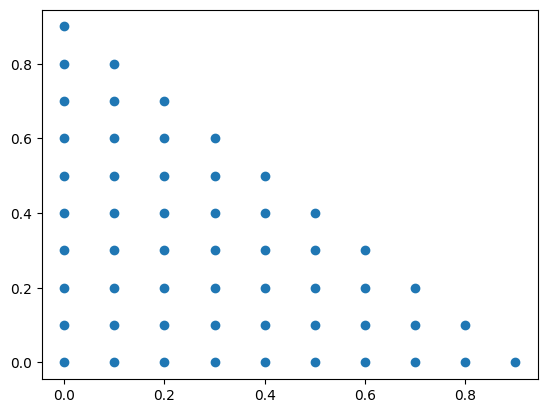

In [4]:
points = []; p1s=[]; p2s=[]
for p1 in np.arange(0,1,0.1):
    for p2 in np.arange(0,1,0.1):
        if 1-p1-p2 >0:
            points.append(np.around([1-p1-p2,p1,p2],2))
            p1s.append(np.around(p1,2))
            p2s.append(np.around(p2,2))
            
plt.scatter(p1s,p2s)


In [104]:

circuits = []
for p in points:
    circuits.append(ks_to_circuit(p))

circuits[10].draw()


q_0: ──────────────────────────────────■────
                                       │    
q_1: ──────────────────────────────────┼──■─
        ┌───────┐                      │  │ 
q_2: ───┤ Ry(0) ├────■─────────────────■──o─
     ┌──┴───────┴──┐ │ ┌─────────────┐ │  │ 
q_3: ┤ Ry(0.32175) ├─■─┤ Ry(0.32175) ├─o──■─
     └─────────────┘   └─────────────┘

### Run Quantum Process tomography

In [107]:
def choi_theoretical(ks):
    '''For some values of taus describing a Pauli channel, this function
    returns the choi matrix of said channel.
    
    Args:
        taus (list): The list of taus [tau1,tau2,tau3] that defines a Pauli channel.
    
    Returns:
        mat_choi (qi.choi): The choi matrix of the channel.
    '''

    
    #First we convert the taus to the ks that describe the channel.
    k0,k1,k2 = ks
    
    #We can write the Kraus representation of the channel, using that the 
    # Kraus operators are \sqrt{k_i} \sigma_i with \sigma_i the ith Pauli matrix.
    
    k = Kraus([np.sqrt(k0)*np.kron(I,I),np.sqrt(k1)*np.kron(Z,I),
                               np.sqrt(k2)*np.kron(I,Z)])
    
    #We convert the Kraus representation to the choi representation of the channel.
    mat_choi = np.array(qtrans._kraus_to_choi([k.data,None]))
    
    return(qi.Choi(mat_choi))



In [105]:
from qiskit_experiments.library import ProcessTomography
import qiskit
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeLima

In [115]:
backend = AerSimulator.from_backend(FakeLima())
# backend = Aer.get_backend('aer_simulator')

fidelities = []
for i in range(len(points)):
    print(i)
    point = points[i]
    circ = circuits[i]
    
    
    qpt = ProcessTomography(circ,backend,measurement_indices=[0,1],
                            preparation_indices=[0,1])
    qpt.set_run_options(shots=20000)
    
    qpt_run = qpt.run()
    qptdata = qpt_run.block_for_results()
    
    
    
    choi_simu = qptdata.analysis_results("state").value
    choi_theo = choi_theoretical(point)
    
    dis =qi.diamond_norm(qi.Choi(choi_simu)-choi_theo)
    fidelities.append(1-0.5*dis)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


In [127]:
with open("Para subir/Simulation-imbq_lima/fidelity-2qbit.csv","w") as f:
    f.write("p1,p2,fid")
    
    for i in range(len(points)):
        f.write("\n" + str(p1s[i]) + "," + str(p2s[i]) + "," + str(fidelities[i]))
        

In [9]:
fidelities =[]

import csv
import pandas as pd


data = pd.read_csv("Para subir/Simulation-imbq_lima/fidelity-2qbit.csv")

        
fidelities = data['fid']
fidelities = np.array(fidelities)

C:\Users\tbasi\AppData\Local\Temp\ipykernel_7848\677954327.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = fig.colorbar(colmap)


Text(0, 0.5, '$k_2$')

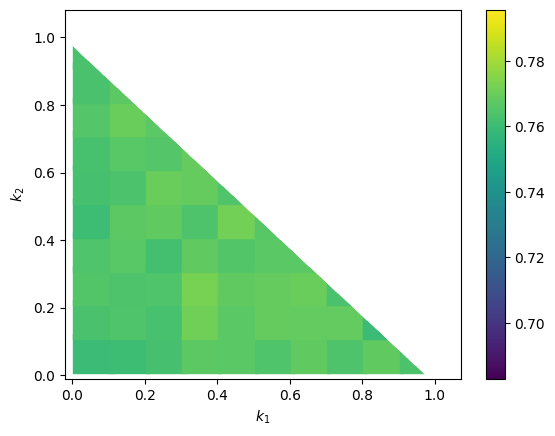

In [114]:
from matplotlib import cm

points = []; p1s=[]; p2s=[]
for p1 in np.arange(0,1,0.1):
    for p2 in np.arange(0,1,0.1):
        if 1-p1-p2 >0:
            points.append(np.around([1-p1-p2,p1,p2],2))
            p1s.append(np.around(p1,2))
            p2s.append(np.around(p2,2))

            
fig = plt.figure()


# colors = cm.rainbow_r((np.array(fidelities)-min(fidelities))/(max(fidelities)-min(fidelities)))

colors = cm.viridis(np.array(fidelities))
for i in range(len(p2s)):
    p2s[i]=p2s[i]+0.065
    
for i in range(len(p1s)):
    p1s[i]=p1s[i]+0.057


colmap = cm.ScalarMappable(cmap=cm.viridis)
colmap.set_array(fidelities)

plt.scatter(p1s,p2s,c=colors,s=800,marker='s')
cb = fig.colorbar(colmap)

a = 1.0325
b= 0.0285
plt.scatter(b,a,c='w',s=800,marker='D')

for j in range(200):
    plt.scatter(b+0.005*j,a-0.005*j,c='w',s=800,marker='D')

plt.xlabel("$k_1$")
plt.ylabel("$k_2$")

In [37]:
a= p2s+[0.4]*len(p2s)

In [38]:
a

[0.0,
 0.1,
 0.2,
 0.3,
 0.4,
 0.5,
 0.6,
 0.7,
 0.8,
 0.9,
 0.0,
 0.1,
 0.2,
 0.3,
 0.4,
 0.5,
 0.6,
 0.7,
 0.8,
 0.0,
 0.1,
 0.2,
 0.3,
 0.4,
 0.5,
 0.6,
 0.7,
 0.0,
 0.1,
 0.2,
 0.3,
 0.4,
 0.5,
 0.6,
 0.0,
 0.1,
 0.2,
 0.3,
 0.4,
 0.5,
 0.0,
 0.1,
 0.2,
 0.3,
 0.4,
 0.0,
 0.1,
 0.2,
 0.3,
 0.0,
 0.1,
 0.2,
 0.0,
 0.1,
 0.0,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4,
 0.4]